In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import random
import matplotlib.pyplot as plt

# k-nearest neighbors

This dataset was obtained from https://archive.ics.uci.edu/ml/datasets/Heart+Disease (this is a great resource for datasets to try machine learning on). It has data on patients that are and are not diagnosed with heart disease.

The attributes are:
* age: age in years 
* sex: sex (1 = male; 0 = female) 
* cp: chest pain type 
 * -- Value 1: typical angina 
 * -- Value 2: atypical angina 
 * -- Value 3: non-anginal pain 
 * -- Value 4: asymptomatic 
* trestbps: resting blood pressure (in mm Hg on admission to the hospital) 
* chol: serum cholestoral in mg/dl 
* fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) 
* restecg: resting electrocardiographic results 
 * -- Value 0: normal 
 * -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) 
 * -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria 
* thalach: maximum heart rate achieved 
* exang: exercise induced angina (1 = yes; 0 = no) 
* oldpeak = ST depression induced by exercise relative to rest 
* slope: the slope of the peak exercise ST segment 
 * -- Value 1: upsloping 
 * -- Value 2: flat 
 * -- Value 3: downsloping 
* ca: number of major vessels (0-3) colored by flourosopy 
* thal: 3 = normal; 6 = fixed defect; 7 = reversable defect 
* num: diagnosis of heart disease (angiographic disease status) 
 * -- Value 0: absence.
 * -- Value 1,2,3,4: presence of heart disease


# Explore the data

Read in the data, modify the dependent variable name and plot a histogram of the ages of patients, both healthy and those with heart disease.

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


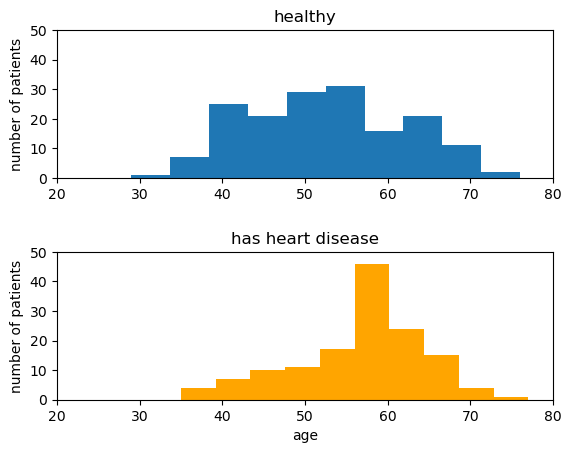

In [4]:
# Comma-separated values
df = pd.read_csv('cleveland.csv')

# Rename 'num' column to 'disease' and change 1,2,3,4 to 1
df = df.rename({'num':'disease'}, axis=1)
df['disease'] = df.disease.apply(lambda x: min(x, 1))
display(df.head(5))

# Plot histograms
fig, (ax1, ax2) = plt.subplots(2, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)

ax1.hist(df[df.disease == 0].age);
# ax1.set_xlabel('age');
ax1.set_ylabel('number of patients');
ax1.set_xlim(20, 80);
ax1.set_ylim(0, 50);
ax1.set_title('healthy');

ax2.hist(df[df.disease == 1].age, color='orange');
ax2.set_xlabel('age');
ax2.set_ylabel('number of patients');
ax2.set_xlim(20, 80);
ax2.set_ylim(0, 50);
ax2.set_title('has heart disease');


# k-nearest neighbors - first try

Try it first on age, using the scikit-learn package. This code simply looks for the **five patients** with ages closest to a given age, then prints how many of those patients are healthy and how many have heart disease.

In [11]:
# Use knn on age. First create a nearest neighbors object.
numOfNeighbors = 5
nn = NearestNeighbors(n_neighbors=numOfNeighbors, metric='euclidean', algorithm='auto')

# Create a two-dimensional array. This is basically a one-dimensional array with
# single-element arrays of patient ages in the second dimension. We're going to
# search for neighbors using only the age dimension.
X = [[x] for x in df.age]

# This builds an index data structure under the hood for query performance
fit = nn.fit(X)

# Find the k nearest neighbors of each age in the query
query = [[65],[40]]
distances, indices = fit.kneighbors(query)
# Displays the patiend ID, not their age
display(indices)

# Get the patients that are near the age
nbrs = df.iloc[indices[0]]
display(nbrs)

# Print how many patients are sick and how many are healthy
healthy = nbrs[nbrs.disease == 0].count().disease
sick = nbrs[nbrs.disease == 1].count().disease
print('healthy: {}\nsick: {}'.format(healthy, sick))


array([[ 48,  73,  70,  40,  51],
       [268,  41,  29,   4, 212]], dtype=int64)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
48,65.0,0.0,3.0,140.0,417.0,1.0,2.0,157.0,0.0,0.8,1.0,1.0,3.0,0
73,65.0,1.0,4.0,110.0,248.0,0.0,2.0,158.0,0.0,0.6,1.0,2.0,6.0,1
70,65.0,0.0,3.0,155.0,269.0,0.0,0.0,148.0,0.0,0.8,1.0,0.0,3.0,0
40,65.0,0.0,4.0,150.0,225.0,0.0,2.0,114.0,0.0,1.0,2.0,3.0,7.0,1
51,65.0,1.0,4.0,120.0,177.0,0.0,0.0,140.0,0.0,0.4,1.0,0.0,7.0,0


healthy: 3
sick: 2


# multiple dimensions

Now run knn on a patient from the database using an additional dimension, or attribute: trestbps (resting blood pressure).

**Warning** The data used in this example is not standardized, so differences in the magnitude of change between the different attributes could cause one attribute to unduly influence another.

In [ ]:
df[['age', 'trestbps']].values

In [18]:
df['age_s'] = (df.age-df.age.mean()/df.age.std())
df['trestbps_s'] = (df.trestbps-df.trestbps.mean()/df.trestbps.std())

In [19]:
# df[['age', 'trestbps']].values
X = df[['age_s', 'trestbps_s']].values
y = df[['disease']].values

# This builds an index data structure under the hood for query performance
fit = nn.fit(X)

# Get a random patient to test on
i = random.randint(0,len(X)-1)
patientX = X[i]
patienty = y[i]
display(df.iloc[i])

# Find the k nearest neighbors to the patient. Problem: the patient
# itself will be found in the list of neighbors!
distances, indices = fit.kneighbors([patientX])
nbrs = df.iloc[indices[0]]
display(nbrs)

healthy = nbrs[nbrs.disease == 0].count().disease
sick = nbrs[nbrs.disease == 1].count().disease
print('healthy: {}\nsick: {}'.format(healthy, sick))
predict = 0 if (healthy > sick) else 1
actual = 0 if (patienty == 0) else 1
success = predict == actual
print(success)

age                60.0
sex                 0.0
cp                  3.0
trestbps          120.0
chol              178.0
fbs                 1.0
restecg             0.0
thalach            96.0
exang               0.0
oldpeak             0.0
slope               1.0
ca                  0.0
thal                3.0
disease               0
age_s         53.977102
trestbps_s    112.51752
Name: 244, dtype: object

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease,age_s,trestbps_s
244,60.0,0.0,3.0,120.0,178.0,1.0,0.0,96.0,0.0,0.0,1.0,0.0,3.0,0,53.977102,112.51752
108,61.0,1.0,4.0,120.0,260.0,0.0,0.0,140.0,1.0,3.6,2.0,1.0,7.0,1,54.977102,112.51752
22,58.0,1.0,2.0,120.0,284.0,0.0,2.0,160.0,0.0,1.8,2.0,0.0,3.0,1,51.977102,112.51752
72,62.0,1.0,4.0,120.0,267.0,0.0,0.0,99.0,1.0,1.8,2.0,2.0,7.0,1,55.977102,112.51752
26,58.0,0.0,3.0,120.0,340.0,0.0,0.0,172.0,0.0,0.0,1.0,0.0,3.0,0,51.977102,112.51752


healthy: 2
sick: 3
False


# multiple tests

In [8]:
X = df[['age', 'trestbps']].values
y = df[['disease']].values

# This builds an index data structure under the hood for query performance
fit = nn.fit(X)

# Get random patients to test on
n = 7
pindices = [random.randint(0,len(X)-1) for _ in range(n)]
patientsX = X[pindices]
patientsy = y[pindices]

# Find the k nearest neighbors to the patient. Problem: we still
# have the problem of the patient itself being found!
distances, indices = fit.kneighbors(patientsX)
print('indices of k-nearest neighbors for each patient:')
display(indices)

for i in range(n):
    print('nearest neighbors to patient: {}:'.format(patientsX[i]))
    nbrs = df.iloc[indices[i]]
    display(nbrs)

# This is where we would compile how many patients are predicted
# correctly.

indices of k-nearest neighbors for each patient:


array([[ 13, 263, 292, 128,  36, 239, 260, 186],
       [ 22,  26,   7,   5, 244, 289, 215, 108],
       [ 62, 206, 102, 107, 279, 267, 301, 300],
       [ 86, 217, 197, 272,  85,  56,  61,  77],
       [114,  92,   8, 118,  44, 249,  24,  54],
       [254, 100, 260,  52, 169, 147, 220, 204],
       [ 13, 263, 292, 128,  36, 239, 260, 186]], dtype=int64)

nearest neighbors to patient: [ 44. 120.]:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
13,44.0,1.0,2.0,120.0,263.0,0.0,0.0,173.0,0.0,0.0,1.0,0.0,7.0,0
263,44.0,1.0,3.0,120.0,226.0,0.0,0.0,169.0,0.0,0.0,1.0,0.0,3.0,0
292,44.0,1.0,4.0,120.0,169.0,0.0,0.0,144.0,1.0,2.8,3.0,0.0,6.0,1
128,44.0,1.0,2.0,120.0,220.0,0.0,0.0,170.0,0.0,0.0,1.0,0.0,3.0,0
36,43.0,1.0,4.0,120.0,177.0,0.0,2.0,120.0,1.0,2.5,2.0,0.0,7.0,1
239,42.0,1.0,2.0,120.0,295.0,0.0,0.0,162.0,0.0,0.0,1.0,0.0,3.0,0
260,44.0,0.0,3.0,118.0,242.0,0.0,0.0,149.0,0.0,0.3,2.0,1.0,3.0,0
186,42.0,1.0,3.0,120.0,240.0,1.0,0.0,194.0,0.0,0.8,3.0,0.0,7.0,0


nearest neighbors to patient: [ 58. 120.]:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
22,58.0,1.0,2.0,120.0,284.0,0.0,2.0,160.0,0.0,1.8,2.0,0.0,3.0,1
26,58.0,0.0,3.0,120.0,340.0,0.0,0.0,172.0,0.0,0.0,1.0,0.0,3.0,0
7,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,0
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
244,60.0,0.0,3.0,120.0,178.0,1.0,0.0,96.0,0.0,0.0,1.0,0.0,3.0,0
289,56.0,1.0,2.0,120.0,240.0,0.0,0.0,169.0,0.0,0.0,3.0,0.0,3.0,0
215,56.0,1.0,1.0,120.0,193.0,0.0,2.0,162.0,0.0,1.9,2.0,0.0,7.0,0
108,61.0,1.0,4.0,120.0,260.0,0.0,0.0,140.0,1.0,3.6,2.0,1.0,7.0,1


nearest neighbors to patient: [ 58. 128.]:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
62,58.0,1.0,4.0,128.0,216.0,0.0,2.0,131.0,1.0,2.2,2.0,3.0,7.0,1
206,58.0,1.0,4.0,128.0,259.0,0.0,2.0,130.0,1.0,3.0,2.0,2.0,7.0,1
102,57.0,0.0,4.0,128.0,303.0,0.0,2.0,159.0,0.0,0.0,1.0,1.0,3.0,0
107,57.0,1.0,3.0,128.0,229.0,0.0,2.0,150.0,0.0,0.4,2.0,1.0,7.0,1
279,58.0,0.0,4.0,130.0,197.0,0.0,0.0,131.0,0.0,0.6,2.0,0.0,3.0,0
267,59.0,1.0,3.0,126.0,218.0,1.0,0.0,134.0,0.0,2.2,2.0,1.0,6.0,1
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,1


nearest neighbors to patient: [ 47. 138.]:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
86,47.0,1.0,3.0,138.0,257.0,0.0,2.0,156.0,0.0,0.0,1.0,0.0,3.0,0
217,46.0,0.0,4.0,138.0,243.0,0.0,2.0,152.0,1.0,0.0,2.0,0.0,3.0,0
197,45.0,0.0,4.0,138.0,236.0,0.0,2.0,152.0,1.0,0.2,2.0,0.0,3.0,0
272,46.0,1.0,4.0,140.0,311.0,0.0,0.0,120.0,1.0,1.8,2.0,2.0,7.0,1
85,44.0,1.0,3.0,140.0,235.0,0.0,2.0,180.0,0.0,0.0,1.0,0.0,3.0,0
56,50.0,1.0,3.0,140.0,233.0,0.0,0.0,163.0,0.0,0.6,2.0,1.0,7.0,1
61,46.0,0.0,3.0,142.0,177.0,0.0,2.0,160.0,1.0,1.4,3.0,0.0,3.0,0
77,51.0,0.0,3.0,140.0,308.0,0.0,2.0,142.0,0.0,1.5,1.0,1.0,3.0,0


nearest neighbors to patient: [ 62. 130.]:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
114,62.0,0.0,3.0,130.0,263.0,0.0,0.0,97.0,0.0,1.2,2.0,1.0,7.0,1
92,62.0,1.0,3.0,130.0,231.0,0.0,0.0,146.0,0.0,1.8,2.0,3.0,7.0,0
8,63.0,1.0,4.0,130.0,254.0,0.0,2.0,147.0,0.0,1.4,2.0,1.0,7.0,1
118,63.0,1.0,4.0,130.0,330.0,1.0,2.0,132.0,1.0,1.8,1.0,3.0,7.0,1
44,61.0,0.0,4.0,130.0,330.0,0.0,2.0,169.0,0.0,0.0,1.0,0.0,3.0,1
249,62.0,1.0,2.0,128.0,208.0,1.0,2.0,140.0,0.0,0.0,1.0,0.0,3.0,0
24,60.0,1.0,4.0,130.0,206.0,0.0,2.0,132.0,1.0,2.4,2.0,2.0,7.0,1
54,60.0,1.0,4.0,130.0,253.0,0.0,0.0,144.0,1.0,1.4,1.0,1.0,7.0,1


nearest neighbors to patient: [ 43. 115.]:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
254,43.0,1.0,4.0,115.0,303.0,0.0,0.0,181.0,0.0,1.2,2.0,0.0,3.0,0
100,45.0,1.0,4.0,115.0,260.0,0.0,2.0,185.0,0.0,0.0,1.0,0.0,3.0,0
260,44.0,0.0,3.0,118.0,242.0,0.0,0.0,149.0,0.0,0.3,2.0,1.0,3.0,0
52,44.0,1.0,4.0,112.0,290.0,0.0,2.0,153.0,0.0,0.0,1.0,1.0,3.0,1
169,45.0,0.0,2.0,112.0,160.0,0.0,0.0,138.0,0.0,0.0,2.0,0.0,3.0,0
147,41.0,1.0,3.0,112.0,250.0,0.0,0.0,179.0,0.0,0.0,1.0,0.0,3.0,0
220,41.0,0.0,3.0,112.0,268.0,0.0,2.0,172.0,1.0,0.0,1.0,0.0,3.0,0
204,43.0,1.0,4.0,110.0,211.0,0.0,0.0,161.0,0.0,0.0,1.0,0.0,7.0,0


nearest neighbors to patient: [ 44. 120.]:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
13,44.0,1.0,2.0,120.0,263.0,0.0,0.0,173.0,0.0,0.0,1.0,0.0,7.0,0
263,44.0,1.0,3.0,120.0,226.0,0.0,0.0,169.0,0.0,0.0,1.0,0.0,3.0,0
292,44.0,1.0,4.0,120.0,169.0,0.0,0.0,144.0,1.0,2.8,3.0,0.0,6.0,1
128,44.0,1.0,2.0,120.0,220.0,0.0,0.0,170.0,0.0,0.0,1.0,0.0,3.0,0
36,43.0,1.0,4.0,120.0,177.0,0.0,2.0,120.0,1.0,2.5,2.0,0.0,7.0,1
239,42.0,1.0,2.0,120.0,295.0,0.0,0.0,162.0,0.0,0.0,1.0,0.0,3.0,0
260,44.0,0.0,3.0,118.0,242.0,0.0,0.0,149.0,0.0,0.3,2.0,1.0,3.0,0
186,42.0,1.0,3.0,120.0,240.0,1.0,0.0,194.0,0.0,0.8,3.0,0.0,7.0,0


# Split data into train/test and get precision/recall/f score

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

k = 20
nn = NearestNeighbors(n_neighbors=k, metric='euclidean', algorithm='auto')

X = df[['age', 'trestbps', 'chol', 'thalach']].values
y = df[['disease']].values

# Use random_state if you want the same values each time you run for debugging,
# but you should select the split randomly when you're ready to actually train
# and test on the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)#, random_state=42)

# Build the model with the training data and test with the test data

# You may also want to use this function to compute the f score. The labels parameter indicates
# that label 1 is "positive" in the sense of "true positive", "false positive" etc.
# (p,r,f,s) = precision_recall_fscore_support(y_test, y_pred, labels=[1])

# Curse of dimensionality
"In low-dimensional datasets, the closest points tend to be much closer than average. But two points are close only if they're close in every dimension, and every extra dimension -- even if just noise -- is another opportunity for each point to be further away from every other point. When you have a lot of dimensions it's likely that the closest points aren't much closer than average, which means that two points being close doesn't mean very much (unless there is a *lot* of structure in your data)." -Joel Grus

The chart that this code displays shows that distance has less meaning as dimensions grows. In higher dimensions, most points are about the same distance from each other.

[0.5459650676074025, 0.2472360335321263, 0.5666315085425512]
[1.6367159203187858, 1.437328618915198, 1.3889510940467507, 1.7925208879775452, 1.4075645397655947, 1.6381163072041158, 1.8805489495908019, 1.213780854458023, 1.340041979843386, 1.4111308645509786]


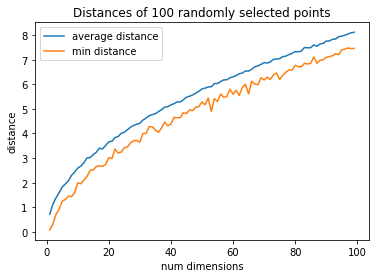

In [19]:
import random
import math

def random_point(dim):
    return [random.random() for _ in range(dim)]

def sq(x):
    return x*x

def distance(a, b):
    a = [sq(a[i]) + sq(b[i]) for i in range(len(a))]
    return math.sqrt(sum(a))

def random_distances(dim, num_pairs):
    return [distance(random_point(dim), random_point(dim)) for _ in range(num_pairs)]

print(random_point(3))
print(random_distances(3, 10))

num_pairs = 100
means = []
mins = []
for dim in range(1, 100):
    d = random_distances(dim, num_pairs)
    means.append(sum(d)/len(d))
    mins.append(min(d))

# Note that the ratio of average distance to min distance
# approaches one, so there's less space between the two.
plt.plot(range(1, 100), means, label='average distance')
plt.plot(range(1, 100), mins, label='min distance')
plt.xlabel('num dimensions')
plt.ylabel('distance')
plt.title('Distances of 100 randomly selected points')
plt.legend()